In [1]:
# %load 2comp_sed.py
#!/usr/bin/env python

### 1D sedimentation simulation

Solve a one-dimensional polydisperse sedimentation problem


$\phi_t + (f(\phi))_x = 0 $

Here $\phi$ is a vector of volume fractions $\in[0,1]$. f is a user-specified function
for the flux of particles.  
The variable state.q is the same as $\phi$. It follows the notation from Leveque's book "Finite Volume Methods for Hyperbolic Problems" 2001.

In [2]:
from __future__ import absolute_import
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt
import velocity_functions as vf

In [3]:
# boundary conditions
def lowerwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,i,...] = qbc[:,2*num_ghost-1-i,...]

def upperwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,-i-1,...] = qbc[:,-2*num_ghost+i,...]
        

def lowerdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.0])
    for i in range(num_ghost):
        qbc[:,i] = bvals

def upperdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.])
    for i in range(num_ghost):
        qbc[:,-i-1] = bvals

In [4]:
def qinit(state,x0,u_rel,IC='dam-break'):
    xc = state.grid.x.centers

In [5]:
def runsim(qinit=None,num_output_times=10,tfinal=1,mx=51,IC='dam-break',
    use_petsc=False,kernel_language='Python',outdir='./_output',solver_type='classic'):

    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Python':
        rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_fwave_1D
#         rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_1D
    elif kernel_language == 'Fortran':
        print('No fortran solver available for advection_nonlinear_1D')
        pass

    if solver_type == 'classic':
        solver = pyclaw.ClawSolver1D(rs)
        solver.limiters = pyclaw.limiters.tvd.vanleer
    elif solver_type == 'sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)

    solver.kernel_language = kernel_language
    solver.cfl_desired = 0.9
    print('solver cfl',solver.cfl_desired)
    solver.order = 2
    print('solver order',solver.order)

    solver.bc_lower[0] = pyclaw.BC.custom
    solver.bc_upper[0] = pyclaw.BC.custom
    
    solver.user_bc_lower = lowerdirichlet
    solver.user_bc_upper = upperdirichlet

    xlower = 0.0
    xupper = 1.0
    mx = mx  # from kwargs
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 2
    state = pyclaw.State(domain,num_eqn)

    # Gravitational constant
    state.problem_data['u_rel'] = np.array([1.,1/30.])
    state.problem_data['efix'] = False
    state.problem_data['basis'] = None
    state.problem_data['hsc_func'] = None #vf.michaels

    xc = state.grid.x.centers
    print(xc)
    if IC=='uniform-all':
        c0 = np.array([0.01,0.])
        # state defaults to empty. Convert to ones and fill with c0
        state.q = np.ones_like(state.q)*c0[:,np.newaxis]

    elif IC=='dam-break':
        # I changed state.is_valid() to always return true for fortran contiguity
        x0 = 0.2
        cr0 = np.array([0.4,0.01])
        cl0 = np.array([0.3,0.05])
        state.q = np.ones_like(state.q)
        state.q = cl0[:,np.newaxis]*(xc <= x0)[np.newaxis,:] + \
                  cr0[:,np.newaxis]*(xc >  x0)[np.newaxis,:]

    elif IC=='perturbation':
        x1 = 0.3
        x2 = 0.7
        eps = 0.5
        scale = 0.25
        state.q[0,:] = scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x1)/eps)**2)
        state.q[1,:] = scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x2)/eps)**2)
    
    elif IC=='linear':
        c1 = 0.45
        c2 = 0
        dc1 = 0.01
        dc2 = 0.1
        state.q[0,:] = np.linspace(c1,c1+dc1,len(xc))
        state.q[1,:] = np.linspace(c2,c2+dc2,len(xc))
    
    claw = pyclaw.Controller()
    claw.keep_copy = True
    claw.num_output_times = num_output_times
    claw.tfinal = tfinal
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.outdir = outdir
    print(state.problem_data)
    
    return claw

How does Q_ave influence to the total net flux?  
How does mass get lost? Sum the fluxes at the interface and see if they equal zero
> interface flux sum $\ne$0  
> compact support for flux removes conservation from F-wave solver  

The interface value for RZ at t=500 is 0.3298

In [20]:
# %%capture
import importlib
importlib.reload(riemann.advection_nonlinear_1D_py)
np.set_printoptions(precision=5,linewidth=np.inf)

ntimes = 100
mx = 101
tfinal = 3
claw = runsim(num_output_times=ntimes,tfinal=tfinal,mx=mx,
              IC='uniform-all')
claw.run()


solver cfl 0.9
solver order 2
[0.00495 0.01485 0.02475 0.03465 0.04455 0.05446 0.06436 0.07426 0.08416 0.09406 0.10396 0.11386 0.12376 0.13366 0.14356 0.15347 0.16337 0.17327 0.18317 0.19307 0.20297 0.21287 0.22277 0.23267 0.24257 0.25248 0.26238 0.27228 0.28218 0.29208 0.30198 0.31188 0.32178 0.33168 0.34158 0.35149 0.36139 0.37129 0.38119 0.39109 0.40099 0.41089 0.42079 0.43069 0.44059 0.4505  0.4604  0.4703  0.4802  0.4901  0.5     0.5099  0.5198  0.5297  0.5396  0.5495  0.55941 0.56931 0.57921 0.58911 0.59901 0.60891 0.61881 0.62871 0.63861 0.64851 0.65842 0.66832 0.67822 0.68812 0.69802 0.70792 0.71782 0.72772 0.73762 0.74752 0.75743 0.76733 0.77723 0.78713 0.79703 0.80693 0.81683 0.82673 0.83663 0.84653 0.85644 0.86634 0.87624 0.88614 0.89604 0.90594 0.91584 0.92574 0.93564 0.94554 0.95545 0.96535 0.97525 0.98515 0.99505]
{'u_rel': array([1.     , 0.03333]), 'efix': False, 'basis': None, 'hsc_func': None}
ascii
2019-05-04 14:21:52,074 INFO CLAW: Solution 0 computed for time t=0.0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.31106e-06  0.00000e+00  1.46215e-05  0.00000e+00  1.46215e-05  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.84320e-04  0.00000e+00  1.92796e-03  0.00000e+00  1.92796e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.29631e-03  0.00000e+00  6.47407e-03  0.00000e+00  6.47407e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.31930e-03  0.00000e+00  1.28633e-03  0.00000e+00  1.28633e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.00000e-02  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.00000e-02  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.00000e-02  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.88074e-12  0.00000e+00  9.76148e-12  0.00000e+00  9.76148e-12  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.59434e-09  0.00000e+00  5.16915e-09  0.00000e+00  5.16915e-09  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.55891e-07  0.00000e+00  1.30142e-06  0.00000e+00  1.30142e-06  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.55021e-04  0.00000e+00  3.07142e-04  0.00000e+00  3.07142e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.48606e-03  0.00000e+00  4.29000e-03  0.00000e+00  4.29000e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.04901e-03  0.00000e+00  4.57167e-03  0.00000e+00  4.57167e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.71732e-03  0.00000e+00  5.32875e-04  0.00000e+00  5.32875e-04  

/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:108: RuntimeWarning: invalid value encountered in true_divide
  J  = (J1-J0)/dx


value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.19374e-12  0.00000e+00  4.38749e-12  0.00000e+00  4.38749e-12  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.17102e-09  0.00000e+00  2.33327e-09  0.00000e+00  2.33327e-09  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.97207e-07  0.00000e+00  5.89739e-07  0.00000e+00  5.89739e-07  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.27076e-05  0.00000e+00  1.44168e-04  0.00000e+00  1.44168e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.48872e-03  0.00000e+00  2.66385e-03  0.00000e+00  2.66385e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.56765e-03  0.00000e+00  5.28898e-03  0.00000e+00  5.28898e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.11458e-03  0.00000e+00  1.53619e-03  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.02781e-18  0.00000e+00  2.05561e-18  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.11392e-16  0.00000e+00  1.81867e-15  0.00000e+00  1.81867e-15  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.64655e-13  0.00000e+00  7.25668e-13  0.00000e+00  7.25668e-13  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.88776e-11  0.00000e+00  1.96300e-10  0.00000e+00  1.96300e-10  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.73806e-08  0.00000e+00  3.43672e-08  0.00000e+00  3.43672e-08  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.11066e-06  0.00000e+00  4.15214e-06  0.00000e+00  4.15214e-06  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.62007e-04  0.00000e+00  3.15333e-04  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.05597e-24  0.00000e+00  2.11194e-24  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.30932e-21  0.00000e+00  2.61442e-21  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.44929e-19  0.00000e+00  1.48463e-18  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.73528e-16  0.00000e+00  5.44082e-16  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.08803e-14  0.00000e+00  1.40669e-13  0.00000e+00  1.40669e-13  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.31976e-11  0.00000e+00  2.61127e-11  0.00000e+00  2.61127e-11  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.80133e-09  0.00000e+00  3.55015e-09  0.00000e+00  3.55015e-09  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.74214e-25  0.00000e+00  9.48428e-25  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.89077e-22  0.00000e+00  1.17626e-21  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.35856e-19  0.00000e+00  6.69358e-19  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.23593e-16  0.00000e+00  2.45846e-16  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.21125e-14  0.00000e+00  6.37321e-14  0.00000e+00  6.37321e-14  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.00013e-12  0.00000e+00  1.18723e-11  0.00000e+00  1.18723e-11  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.22732e-10  0.00000e+00  1.62159e-09  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.77652e-27  0.00000e+00  9.55304e-27  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.49578e-24  0.00000e+00  1.29724e-23  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.07651e-21  0.00000e+00  8.12706e-21  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.64112e-18  0.00000e+00  3.26596e-18  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.69889e-16  0.00000e+00  9.33231e-16  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.85548e-14  0.00000e+00  1.95237e-13  0.00000e+00  1.95237e-13  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.54324e-11  0.00000e+00  3.04725e-11  0.00000

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.83746e-31  0.00000e+00  9.67492e-31  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.71714e-28  0.00000e+00  1.54149e-27  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.73574e-25  0.00000e+00  1.14406e-24  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.71934e-22  0.00000e+00  5.41577e-22  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.22985e-20  0.00000e+00  1.83512e-19  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.34739e-17  0.00000e+00  4.65798e-17  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.57694e-15  0.00000e+00  9.06035e-15  0.00000e+00  9.06035e-15  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.89881e-13  0.00000e+00  1.36155e

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.17221e-31  0.00000e+00  4.34441e-31  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.47025e-28  0.00000e+00  6.93182e-28  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.58340e-25  0.00000e+00  5.15292e-25  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.22690e-22  0.00000e+00  2.44348e-22  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.17223e-20  0.00000e+00  8.29548e-20  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.06350e-17  0.00000e+00  2.11036e-17  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.07931e-15  0.00000e+00  4.11626e-15  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.20671e-37  0.00000e+00  4.41342e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.30385e-34  0.00000e+00  8.59887e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.95566e-31  0.00000e+00  7.89411e-31  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.31775e-28  0.00000e+00  4.61970e-28  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.76239e-26  0.00000e+00  1.94322e-25  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.13064e-23  0.00000e+00  6.22232e-23  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.88004e-21  0.00000e+00  1.56352e-20  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.90843e-38  0.00000e+00  1.98169e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.93474e-34  0.00000e+00  3.86551e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.78051e-31  0.00000e+00  3.55328e-31  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.04470e-28  0.00000e+00  2.08229e-28  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.40691e-26  0.00000e+00  8.77211e-26  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.41560e-23  0.00000e+00  2.81362e-23  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.57008e-21  0.00000e+00  7.08372e-21  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.95413e-40  0.00000e+00  1.99083e-39  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.06065e-36  0.00000e+00  4.11732e-36  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.01669e-33  0.00000e+00  4.02514e-33  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.25917e-30  0.00000e+00  2.51028e-30  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.65772e-28  0.00000e+00  1.12652e-27  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.94155e-25  0.00000e+00  3.86051e-25  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.25642e-23  0.00000e+00  1.04354e-22  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.99742e-42  0.00000e+00  1.99948e-41  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.18709e-38  0.00000e+00  4.37018e-38  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.26823e-35  0.00000e+00  4.52771e-35  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.50207e-32  0.00000e+00  2.99508e-32  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.16494e-30  0.00000e+00  1.42699e-29  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.61650e-27  0.00000e+00  5.20440e-27  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.56805e-25  0.00000e+00  1.50317e-24  0.00000e+00  0.00000e+00  

2019-05-04 14:21:52,809 INFO CLAW: Solution 7 computed for time t=0.210000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.50728e-44  0.00000e+00  9.01456e-44  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.04001e-40  0.00000e+00  2.07821e-40  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.14063e-37  0.00000e+00  2.27709e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.99641e-35  0.00000e+00  1.59472e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.04209e-32  0.00000e+00  8.05223e-32  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.56752e-29  0.00000e+00  3.11890e-29  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.52487e-46  0.00000e+00  9.04974e-46  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.09721e-42  0.00000e+00  2.19262e-42  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.26755e-39  0.00000e+00  2.53072e-39  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.37004e-37  0.00000e+00  1.86894e-36  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.99891e-34  0.00000e+00  9.96039e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.04944e-31  0.00000e+00  4.07892e-31  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.69607e-29  0.00000e+00  1.33104e-28  0.00000e+00  0.00000e+00  

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.55776e-50  0.00000e+00  9.11551e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.21223e-46  0.00000e+00  2.42263e-46  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.54233e-43  0.00000e+00  3.07982e-43  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.25839e-40  0.00000e+00  2.51062e-40  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.42345e-38  0.00000e+00  1.47966e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.37469e-35  0.00000e+00  6.71973e-35  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.22788e-32  0.00000e+00  2.44228e-32  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.66211e-30  0.00000e+00  7.27525e

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.04636e-50  0.00000e+00  4.09271e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.44732e-47  0.00000e+00  1.08865e-46  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.93707e-44  0.00000e+00  1.38524e-43  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.66552e-41  0.00000e+00  1.13033e-40  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.34569e-38  0.00000e+00  6.66875e-38  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.52266e-35  0.00000e+00  3.03197e-35  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.54702e-33  0.00000e+00  1.10333e-32  0.00000

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.05328e-52  0.00000e+00  4.10655e-52  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.70679e-49  0.00000e+00  1.14054e-48  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.60166e-46  0.00000e+00  1.51805e-45  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.50075e-43  0.00000e+00  1.29711e-42  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.02336e-40  0.00000e+00  8.02076e-40  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.92134e-37  0.00000e+00  3.82661e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.35709e-35  0.00000e+00  1.46375e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.31497e-32  0.00000e+00  4.60058e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.05993e-54  0.00000e+00  4.11986e-54  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.96708e-51  0.00000e+00  1.19259e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.29783e-48  0.00000e+00  1.65718e-47  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.41591e-45  0.00000e+00  1.47987e-44  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.80087e-42  0.00000e+00  9.57212e-42  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.40070e-39  0.00000e+00  4.78223e-39  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.64067e-37  0.00000e+00  1.91855e-36  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.06633e-56  0.00000e+00  4.13266e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.22815e-53  0.00000e+00  1.24480e-52  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.02567e-50  0.00000e+00  1.80264e-49  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.41483e-47  0.00000e+00  1.67936e-46  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.68776e-44  0.00000e+00  1.13419e-43  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.97264e-41  0.00000e+00  5.92256e-41  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.24936e-38  0.00000e+00  2.48685e-38  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.27727e-57  0.00000e+00  1.85545e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.79836e-53  0.00000e+00  5.59301e-53  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.05857e-50  0.00000e+00  8.10594e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.78713e-47  0.00000e+00  7.55803e-47  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.56213e-44  0.00000e+00  5.10913e-44  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.34036e-41  0.00000e+00  2.67049e-41  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.63923e-39  0.00000e+00  1.12249e-38  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.33169e-61  0.00000e+00  1.86634e-60  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.03378e-57  0.00000e+00  6.06384e-57  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.75545e-54  0.00000e+00  9.49878e-54  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.80525e-51  0.00000e+00  9.59149e-51  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.52626e-48  0.00000e+00  7.03333e-48  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.00467e-45  0.00000e+00  3.99526e-45  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.18686e-43  0.00000e+00  1.82937e-42  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.35753e-63  0.00000e+00  1.87151e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.15198e-59  0.00000e+00  6.30021e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.12538e-56  0.00000e+00  1.02382e-55  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.37759e-53  0.00000e+00  1.07347e-52  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.10081e-50  0.00000e+00  8.18013e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.42464e-47  0.00000e+00  4.83291e-47  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.15683e-44  0.00000e+00  2.30398e-44  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.20121e-63  0.00000e+00  8.40242e-63  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.41607e-59  0.00000e+00  2.83047e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.30430e-56  0.00000e+00  4.60293e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.41951e-53  0.00000e+00  4.82981e-53  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.84653e-50  0.00000e+00  3.68340e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.09271e-47  0.00000e+00  2.17804e-47  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.21815e-45  0.00000e+00  1.03927e-44  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.21243e-65  0.00000e+00  8.42486e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.46927e-61  0.00000e+00  2.93686e-61  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.47695e-58  0.00000e+00  4.94803e-58  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.69682e-55  0.00000e+00  5.38375e-55  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.13580e-52  0.00000e+00  4.26083e-52  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.31261e-49  0.00000e+00  2.61668e-49  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.51609e-47  0.00000e+00  1.29798e-46  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.23385e-69  0.00000e+00  8.46771e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.57607e-65  0.00000e+00  3.15045e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.84168e-62  0.00000e+00  5.67707e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.31450e-59  0.00000e+00  6.61764e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.81623e-56  0.00000e+00  5.61921e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.85965e-53  0.00000e+00  3.70804e-53  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.93607e-51  0.00000e+00  1.97979e-50  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.90083e-69  0.00000e+00  3.80166e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.08018e-66  0.00000e+00  1.41528e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.27739e-62  0.00000e+00  2.55194e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.49093e-59  0.00000e+00  2.97676e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.26770e-56  0.00000e+00  2.52945e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.37736e-54  0.00000e+00  1.67041e-53  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.47958e-51  0.00000e+00  8.92569e-51  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.90542e-71  0.00000e+00  3.81085e-71  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.32077e-68  0.00000e+00  1.46339e-67  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.36369e-64  0.00000e+00  2.72445e-64  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.64463e-61  0.00000e+00  3.28381e-61  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.44592e-58  0.00000e+00  2.88527e-58  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.88676e-56  0.00000e+00  1.97157e-55  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.47443e-53  0.00000e+00  1.09094e-52  0.00000

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.90989e-73  0.00000e+00  3.81978e-73  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.56191e-70  0.00000e+00  1.51162e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.45291e-66  0.00000e+00  2.90280e-66  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.80870e-63  0.00000e+00  3.61160e-63  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.64251e-60  0.00000e+00  3.27778e-60  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.16083e-57  0.00000e+00  2.31509e-57  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.64847e-55  0.00000e+00  1.32506e-54  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.17131e-52  0.00000e+00  6.31608e

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.91423e-75  0.00000e+00  3.82846e-75  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.80359e-72  0.00000e+00  1.55995e-71  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.54507e-68  0.00000e+00  3.08702e-68  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.98350e-65  0.00000e+00  3.96082e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.85869e-62  0.00000e+00  3.70944e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.35637e-59  0.00000e+00  2.70531e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.02684e-57  0.00000e+00  1.59995e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.95930e-54  0.00000e+00  7.88654e

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.59402e-76  0.00000e+00  1.71880e-75  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.50538e-72  0.00000e+00  7.00732e-72  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.94451e-69  0.00000e+00  1.38750e-68  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.92052e-66  0.00000e+00  1.78133e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.36457e-63  0.00000e+00  1.66935e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.10814e-60  0.00000e+00  1.21829e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.61730e-57  0.00000e+00  7.21020e-57  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.61299e-78  0.00000e+00  1.72260e-77  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.61411e-74  0.00000e+00  7.22478e-74  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.37168e-71  0.00000e+00  1.47289e-70  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.75594e-68  0.00000e+00  1.94824e-67  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.43071e-65  0.00000e+00  1.88224e-64  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.10392e-62  0.00000e+00  1.41702e-61  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.34255e-59  0.00000e+00  8.65672e-59  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.63147e-80  0.00000e+00  1.72629e-79  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.72307e-76  0.00000e+00  7.44269e-76  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.81206e-73  0.00000e+00  1.56092e-72  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.06427e-69  0.00000e+00  2.12542e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.05966e-66  0.00000e+00  2.11508e-66  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.22655e-64  0.00000e+00  1.64108e-63  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.18598e-61  0.00000e+00  1.03391e-60  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.64949e-82  0.00000e+00  1.72990e-81  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.83225e-78  0.00000e+00  7.66105e-78  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.26570e-75  0.00000e+00  1.65161e-74  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.15824e-71  0.00000e+00  2.31317e-71  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.18685e-68  0.00000e+00  2.36907e-68  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.48793e-66  0.00000e+00  1.89284e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.16266e-63  0.00000e+00  1.22874e-62  0.00000

 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]]
ascii
2019-05-04 14:21:53,487 INFO CLAW: Solution 13 computed for time t=0.390000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.88319e-82  0.00000e+00  7.76638e-82  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.72136e-78  0.00000e+00  3.44117e-78  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.71473e-75  0.00000e+00  7.42258e-75  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.20821e-72  0.00000e+00  1.04016e-71  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.33999e-69  0.00000e+00  1.06592e-68  0.00000e+00  0.00000e+00  0.000

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.89107e-84  0.00000e+00  7.78215e-84  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.77047e-80  0.00000e+00  3.53939e-80  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.92446e-77  0.00000e+00  7.84183e-77  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.65502e-74  0.00000e+00  1.12943e-73  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.96236e-71  0.00000e+00  1.19021e-70  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.90713e-68  0.00000e+00  9.79043e-68  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.28334e-65  0.00000e+00  6.54708e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.83619e-62  0.00000e+00  3.65928e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.89878e-86  0.00000e+00  7.79755e-86  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.81968e-82  0.00000e+00  3.63781e-82  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.14015e-79  0.00000e+00  8.27302e-79  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.12702e-76  0.00000e+00  1.22375e-75  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.63810e-73  0.00000e+00  1.32517e-72  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.61680e-70  0.00000e+00  1.12071e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.86588e-67  0.00000e+00  7.70932e-67  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.90630e-88  0.00000e+00  7.81260e-88  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.86899e-84  0.00000e+00  3.73641e-84  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.36182e-81  0.00000e+00  8.71617e-81  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.62495e-78  0.00000e+00  1.32325e-77  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.37021e-75  0.00000e+00  1.47139e-74  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.40686e-72  0.00000e+00  1.27843e-71  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.53263e-69  0.00000e+00  9.03967e-69  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.75372e-88  0.00000e+00  3.50744e-88  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.39466e-85  0.00000e+00  1.67823e-84  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.96010e-81  0.00000e+00  3.91684e-81  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.97862e-78  0.00000e+00  5.94941e-78  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.31547e-75  0.00000e+00  6.61904e-75  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.88373e-72  0.00000e+00  5.75420e-72  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.04133e-69  0.00000e+00  4.07114e-69  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.76024e-92  0.00000e+00  3.52048e-92  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.83855e-89  0.00000e+00  1.76701e-88  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.16731e-85  0.00000e+00  4.33108e-85  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.46236e-82  0.00000e+00  6.91605e-82  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.05542e-79  0.00000e+00  8.09700e-79  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.71525e-76  0.00000e+00  7.41430e-76  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.77277e-73  0.00000e+00  5.53069e-73  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.76340e-94  0.00000e+00  3.52680e-94  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.06109e-91  0.00000e+00  1.81151e-90  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.27496e-87  0.00000e+00  4.54630e-87  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.72298e-84  0.00000e+00  7.43687e-84  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.46908e-81  0.00000e+00  8.92329e-81  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.19787e-78  0.00000e+00  8.37789e-78  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.21375e-75  0.00000e+00  6.41072e-75  0.00000e+00  0.00000e+00  

2019-05-04 14:21:53,706 INFO CLAW: Solution 15 computed for time t=0.450000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.91665e-95  0.00000e+00  1.58333e-94  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.06968e-91  0.00000e+00  8.13620e-91  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.02224e-87  0.00000e+00  2.04285e-87  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.67369e-84  0.00000e+00  3.34329e-84  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.01010e-81  0.00000e+00  4.01350e-81  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.88908e-78  0.00000e+00  3.77014e-78  0.00000e+00  0.00000e+00  0.00000e+00 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.93052e-97  0.00000e+00  1.58610e-96  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.16976e-93  0.00000e+00  8.33634e-93  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.07180e-89  0.00000e+00  2.14194e-89  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.79661e-86  0.00000e+00  3.58893e-86  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.21005e-83  0.00000e+00  4.41292e-83  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.12829e-80  0.00000e+00  4.24775e-80  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.67121e-77  0.00000e+00  3.33392e-77  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.94410e-99  0.00000e+00  1.58882e-98  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.27000e-95  0.00000e+00  8.53683e-95  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.12259e-91  0.00000e+00  2.24346e-91  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.92548e-88  0.00000e+00  3.84648e-88  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.42469e-85  0.00000e+00  4.84167e-85  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.39128e-82  0.00000e+00  4.77288e-82  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.92381e-79  0.00000e+00  3.83806e-79  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.95741e-101  0.00000e+000  1.59148e-100  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.37041e-097  0.00000e+000  8.73765e-097  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.17459e-093  0.00000e+000  2.34742e-093  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.06046e-090  0.00000e+000  4.11622e-090  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.65471e-087  0.00000e+000  5.30118e-087  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.67981e-084  0.00000e+000  5.34900e-084  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.57240e-101  0.00000e+000  7.14480e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.96285e-097  0.00000e+000  3.92428e-097  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.27757e-094  0.00000e+000  1.05473e-093  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.26199e-091  0.00000e+000  1.85029e-090  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19387e-087  0.00000e+000  2.38403e-087  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20573e-084  0.00000e+000  2.40669e-084  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.58399e-105  0.00000e+000  7.16799e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05322e-101  0.00000e+000  4.10501e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.76111e-098  0.00000e+000  1.15140e-097  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05598e-094  0.00000e+000  2.10965e-094  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.42273e-091  0.00000e+000  2.84124e-091  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.50301e-088  0.00000e+000  3.00034e-088  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.58963e-107  0.00000e+000  7.17925e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.09852e-103  0.00000e+000  4.19560e-103  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.01112e-100  0.00000e+000  1.20138e-099  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12524e-096  0.00000e+000  2.24808e-096  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.54887e-093  0.00000e+000  3.09323e-093  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.67229e-090  0.00000e+000  3.33840e-090  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61152e-107  0.00000e+000  3.22304e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.42463e-104  0.00000e+000  1.88428e-103  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.70072e-100  0.00000e+000  5.39767e-100  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.05765e-097  0.00000e+000  1.01045e-096  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.96471e-094  0.00000e+000  1.39092e-093  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.52306e-091  0.00000e+000  1.50183e-090  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61400e-109  0.00000e+000  3.22800e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.62826e-106  0.00000e+000  1.92501e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.81547e-102  0.00000e+000  5.62710e-102  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.38232e-099  0.00000e+000  1.07534e-098  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.56883e-096  0.00000e+000  1.51161e-095  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.35173e-093  0.00000e+000  1.66732e-092  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61644e-111  0.00000e+000  3.23287e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.83220e-108  0.00000e+000  1.96579e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.93270e-104  0.00000e+000  5.86147e-104  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.72079e-101  0.00000e+000  1.14299e-100  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.21171e-098  0.00000e+000  1.64006e-097  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.25225e-095  0.00000e+000  1.84717e-094  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61883e-113  0.00000e+000  3.23766e-113  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00364e-109  0.00000e+000  2.00664e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05241e-106  0.00000e+000  6.10080e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.07334e-103  0.00000e+000  1.21345e-102  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.89500e-100  0.00000e+000  1.77657e-099  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02292e-096  0.00000e+000  2.04229e-096  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9

ascii
2019-05-04 14:21:54,052 INFO CLAW: Solution 18 computed for time t=0.540000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.26750e-114  0.00000e+000  1.45350e-113  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.50733e-110  0.00000e+000  9.01175e-110  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37134e-106  0.00000e+000  2.74088e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.72959e-103  0.00000e+000  5.45370e-103  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.99936e-100  0.00000e+000  7.98781e-100  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.60117e-097  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.27805e-116  0.00000e+000  1.45561e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.59915e-112  0.00000e+000  9.19539e-112  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.42621e-108  0.00000e+000  2.85059e-108  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.89444e-105  0.00000e+000  5.78317e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.32538e-102  0.00000e+000  8.63918e-102  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.07698e-099  0.00000e+000  1.01367e-098  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.29861e-120  0.00000e+000  1.45972e-119  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.78317e-116  0.00000e+000  9.56342e-116  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.53931e-112  0.00000e+000  3.07671e-112  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.24403e-109  0.00000e+000  6.48191e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.03723e-106  0.00000e+000  1.00615e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.14726e-103  0.00000e+000  1.22744e-102  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27659e-120  0.00000e+000  6.55319e-120  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14806e-116  0.00000e+000  4.29480e-116  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.91528e-113  0.00000e+000  1.38220e-112  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.45790e-109  0.00000e+000  2.91303e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.26463e-106  0.00000e+000  4.52342e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.76475e-103  0.00000e+000  5.52045e-103  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.28109e-122  0.00000e+000  6.56219e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.18945e-118  0.00000e+000  4.37758e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.17676e-115  0.00000e+000  1.43448e-114  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.54102e-111  0.00000e+000  3.07916e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.43874e-108  0.00000e+000  4.87132e-108  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.03416e-105  0.00000e+000  6.05858e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.28552e-124  0.00000e+000  6.57104e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.23089e-120  0.00000e+000  4.46048e-120  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.44328e-117  0.00000e+000  1.48776e-116  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.62728e-113  0.00000e+000  3.25158e-113  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.62278e-110  0.00000e+000  5.23904e-110  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.32428e-107  0.00000e+000  6.63807e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.28988e-126  0.00000e+000  6.57975e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.27240e-122  0.00000e+000  4.54347e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.71483e-119  0.00000e+000  1.54206e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.71674e-115  0.00000e+000  3.43039e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.81711e-112  0.00000e+000  5.62735e-112  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.63628e-109  0.00000e+000  7.26129e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

ascii
2019-05-04 14:21:54,274 INFO CLAW: Solution 20 computed for time t=0.600000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.47693e-126  0.00000e+000  2.95386e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02048e-122  0.00000e+000  2.04037e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.46571e-119  0.00000e+000  6.92733e-119  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.71471e-116  0.00000e+000  1.54156e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.26641e-112  0.00000e+000  2.52973e-112  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.63526e-109  0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.48075e-130  0.00000e+000  2.96150e-130  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05781e-126  0.00000e+000  2.11503e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.71640e-123  0.00000e+000  7.42857e-123  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.56269e-120  0.00000e+000  1.71105e-119  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.45563e-116  0.00000e+000  2.90784e-116  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.94750e-113  0.00000e+000  3.88919e-113  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.13598e-110  0.00000e+000  4.26418e-110  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.48262e-132  0.00000e+000  2.96523e-132  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.07652e-128  0.00000e+000  2.15244e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.84515e-125  0.00000e+000  7.68599e-125  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.00933e-122  0.00000e+000  1.80033e-121  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.55788e-118  0.00000e+000  3.11217e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.12065e-115  0.00000e+000  4.23508e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.65592e-133  0.00000e+000  1.33118e-132  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.83429e-129  0.00000e+000  9.66591e-129  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72728e-125  0.00000e+000  3.45263e-125  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.04841e-122  0.00000e+000  8.08991e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.00282e-119  0.00000e+000  1.39895e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.53583e-116  0.00000e+000  1.90437e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.66416e-135  0.00000e+000  1.33283e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.91834e-131  0.00000e+000  9.83402e-131  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.78612e-127  0.00000e+000  3.57027e-127  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25599e-124  0.00000e+000  8.50484e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.48625e-121  0.00000e+000  1.49555e-120  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03688e-117  0.00000e+000  2.07077e-117  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.17789e-114  0.00000e+000  2.35163e-114  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.68031e-139  0.00000e+000  1.33606e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.08676e-135  0.00000e+000  1.01709e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.90686e-131  0.00000e+000  3.81169e-131  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.69248e-128  0.00000e+000  9.37734e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.52827e-125  0.00000e+000  1.70378e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.22102e-121  0.00000e+000  2.43862e-121  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

2019-05-04 14:21:54,480 INFO CLAW: Solution 22 computed for time t=0.660000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.99898e-139  0.00000e+000  5.99797e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.28426e-135  0.00000e+000  4.56733e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.56554e-132  0.00000e+000  1.71219e-131  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.10850e-128  0.00000e+000  4.21357e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.83328e-125  0.00000e+000  7.65812e-125  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.49002e-122  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.00253e-141  0.00000e+000  6.00506e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.32213e-137  0.00000e+000  4.64307e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.84354e-134  0.00000e+000  1.76778e-133  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.21143e-130  0.00000e+000  4.41932e-130  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.08504e-127  0.00000e+000  8.16124e-127  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.94596e-124  0.00000e+000  1.18756e-123  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.00947e-145  0.00000e+000  6.01895e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.39800e-141  0.00000e+000  4.79480e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.41334e-138  0.00000e+000  1.88171e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.42737e-134  0.00000e+000  4.85097e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.62582e-131  0.00000e+000  9.24194e-131  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.94910e-128  0.00000e+000  1.38797e-127  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.35104e-145  0.00000e+000  2.70207e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.07683e-141  0.00000e+000  2.15312e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.22831e-138  0.00000e+000  8.45231e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.09065e-134  0.00000e+000  2.17961e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.07909e-131  0.00000e+000  4.15381e-131  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.12427e-128  0.00000e+000  6.24022e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.35407e-149  0.00000e+000  2.70813e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11097e-145  0.00000e+000  2.22139e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.49246e-142  0.00000e+000  8.98048e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19384e-138  0.00000e+000  2.38589e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.34559e-135  0.00000e+000  4.68641e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.63430e-132  0.00000e+000  7.25923e-132  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.62555e-129  0.00000e+000  9.23657e-129  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.35555e-151  0.00000e+000  2.71111e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12806e-147  0.00000e+000  2.25559e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.62765e-144  0.00000e+000  9.25079e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.24783e-140  0.00000e+000  2.49380e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.48813e-137  0.00000e+000  4.97127e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.91327e-134  0.00000e+000  7.81660e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.05666e-131  0.00000e+000  1.00977e-130  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.08544e-152  0.00000e+000  1.21709e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.06553e-148  0.00000e+000  1.01286e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.07860e-144  0.00000e+000  4.15518e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.60645e-141  0.00000e+000  1.12046e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11823e-137  0.00000e+000  2.23423e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.75926e-134  0.00000e+000  3.51404e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.09202e-154  0.00000e+000  1.21840e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.14236e-150  0.00000e+000  1.02823e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14024e-146  0.00000e+000  4.27843e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.85621e-143  0.00000e+000  1.17039e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18517e-139  0.00000e+000  2.36800e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.89225e-136  0.00000e+000  3.77976e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.09851e-156  0.00000e+000  1.21970e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21928e-152  0.00000e+000  1.04361e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.20281e-148  0.00000e+000  4.40354e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.11337e-145  0.00000e+000  1.22179e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25509e-141  0.00000e+000  2.50773e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03320e-138  0.00000e+000  4.06138e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.10493e-158  0.00000e+000  1.22099e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.29627e-154  0.00000e+000  1.05901e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.26632e-150  0.00000e+000  4.53053e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.37804e-147  0.00000e+000  1.27470e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32807e-143  0.00000e+000  2.65360e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.18246e-140  0.00000e+000  4.35962e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.74066e-158  0.00000e+000  5.48132e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.37824e-154  0.00000e+000  4.75538e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.01794e-150  0.00000e+000  2.03493e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.86553e-147  0.00000e+000  5.72699e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.96843e-144  0.00000e+000  1.19254e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.81090e-141  0.00000e+000  1.95979e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.74350e-160  0.00000e+000  5.48700e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.41284e-156  0.00000e+000  4.82458e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.04688e-152  0.00000e+000  2.09279e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.98784e-149  0.00000e+000  5.97149e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.31054e-146  0.00000e+000  1.26091e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05207e-142  0.00000e+000  2.10162e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.74631e-162  0.00000e+000  5.49262e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.44747e-158  0.00000e+000  4.89384e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.07623e-154  0.00000e+000  2.15149e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.11362e-151  0.00000e+000  6.22293e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.66724e-148  0.00000e+000  1.33220e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.74899e-164  0.00000e+000  5.49798e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.48214e-160  0.00000e+000  4.96318e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.10601e-156  0.00000e+000  2.21103e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.24293e-153  0.00000e+000  6.48143e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.03895e-150  0.00000e+000  1.40649e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20641e-146  0.00000e+000  2.41000e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18161e-164  0.00000e+000  2.97102e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11460e-160  0.00000e+000  2.22860e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.96764e-157  0.00000e+000  9.93083e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.45693e-153  0.00000e+000  2.91188e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.16320e-150  0.00000e+000  6.32057e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.42288e-147  0.00000e+000  1.08331e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.15651e-166  0.00000e+000  3.35387e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.26555e-164  0.00000e+000  2.46403e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.24110e-161  0.00000e+000  1.04772e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.57793e-157  0.00000e+000  3.15376e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.51818e-154  0.00000e+000  7.03005e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.19590e-151  0.00000e+000  1.23777e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.39868e-163  0.00000e+000  1.08007e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.64090e-159  0.00000e+000  3.27963e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.70655e-156  0.00000e+000  7.40654e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.61427e-153  0.00000e+000  1.32137e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9

ascii
2019-05-04 14:21:55,027 INFO CLAW: Solution 27 computed for time t=0.810000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.42454e-163  0.00000e+000  6.04309e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.37236e-160  0.00000e+000  1.47326e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.66560e-156  0.00000e+000  3.32824e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.97300e-153  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.06285e-165  0.00000e+000  3.33196e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.74162e-162  0.00000e+000  1.54166e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.75360e-158  0.00000e+000  3.50412e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.17107e-155  0.00000e+000  6.33513e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.66598e-165  0.00000e+000  4.83134e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.64625e-164  0.00000e+000  1.83262e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.84590e-160  0.00000e+000  3.68804e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.37960e-157  0.00000e+000  6.75182e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.49360e-165  0.00000e+000  1.45335e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.96283e-162  0.00000e+000  3.89659e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.59909e-159  0.00000e+000  7.19036e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.86871e-165  0.00000e+000  1.13441e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.87753e-163  0.00000e+000  1.75282e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61767e-159  0.00000e+000  3.23180e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.67204e-166  0.00000e+000  1.64489e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.52711e-164  0.00000e+000  2.72524e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72296e-161  0.00000e+000  3.44014e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.30432e-165  0.00000e+000  5.59649e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.90253e-163  0.00000e+000  3.69313e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.98691e-165  0.00000e+000  2.57814e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.63678e-165  0.00000e+000  2.01237e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00618e-165  0.00000e+000  2.91794e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

ascii
2019-05-04 14:21:56,058 INFO CLAW: Solution 36 computed for time t=1.080000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:56,183 INFO CLAW: Solution 37 computed for time t=1.110000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

ascii
2019-05-04 14:21:56,515 INFO CLAW: Solution 40 computed for time t=1.200000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:56,724 INFO CLAW: Solution 42 computed for time t=1.260000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:56,937 INFO CLAW: Solution 44 computed for time t=1.320000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

ascii
2019-05-04 14:21:57,230 INFO CLAW: Solution 47 computed for time t=1.410000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

2019-05-04 14:21:57,336 INFO CLAW: Solution 48 computed for time t=1.440000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:57,429 INFO CLAW: Solution 49 computed for time t=1.470000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

ascii
2019-05-04 14:21:57,585 INFO CLAW: Solution 50 computed for time t=1.500000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:58,141 INFO CLAW: Solution 55 computed for time t=1.650000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

ascii
2019-05-04 14:21:58,245 INFO CLAW: Solution 56 computed for time t=1.680000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:58,350 INFO CLAW: Solution 57 computed for time t=1.710000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

ascii
2019-05-04 14:21:58,447 INFO CLAW: Solution 58 computed for time t=1.740000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:58,573 INFO CLAW: Solution 59 computed for time t=1.770000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

ascii
2019-05-04 14:21:58,858 INFO CLAW: Solution 62 computed for time t=1.860000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

ascii
2019-05-04 14:21:58,962 INFO CLAW: Solution 63 computed for time t=1.890000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

2019-05-04 14:21:59,342 INFO CLAW: Solution 66 computed for time t=1.980000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

ascii
2019-05-04 14:21:59,557 INFO CLAW: Solution 68 computed for time t=2.040000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

ascii
2019-05-04 14:22:00,126 INFO CLAW: Solution 73 computed for time t=2.190000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

ascii
2019-05-04 14:22:00,714 INFO CLAW: Solution 78 computed for time t=2.340000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
ascii
2019-05-04 14:22:01,658 INFO CLAW: Solution 86 computed for time t=2.580000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

ascii
2019-05-04 14:22:01,941 INFO CLAW: Solution 90 computed for time t=2.700000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00 

[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]]
ascii
2019-05-04 14:22:02,046 INFO CLAW: Solution 92 computed for time t=2.760000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

2019-05-04 14:22:02,410 INFO CLAW: Solution 98 computed for time t=2.940000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.000

 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]]
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

{'cflmax': 0.9248415115061712,
 'dtmin': 0.00891089099224042,
 'dtmax': 0.02094110008211581,
 'numsteps': 374}

When $\phi_{interface}$ is 0.398, the value in the left cell goes negative, and the flux decreases below 0

(101, 202)


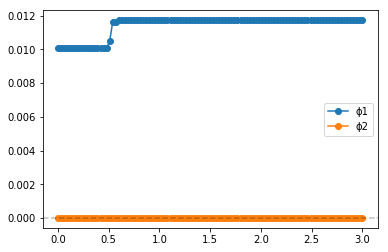

In [21]:
xs = np.linspace(0,1,mx)
times = np.linspace(0,tfinal,ntimes+1)
dx = xs[1]-xs[0]

result = np.vstack([frame.q for frame in claw.frames]).T
print(result.shape)

plt.plot(times,np.sum(result[:,0::2],axis=0)*dx,'o-')
plt.plot(times,np.sum(result[:,1::2],axis=0)*dx,'o-')
plt.axhline(y=0,color='black',linestyle='--',alpha=0.25)
plt.legend(['ϕ1','ϕ2'])
plt.show()

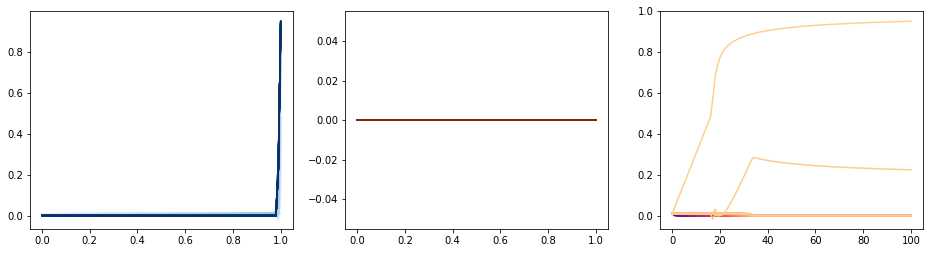

0.9493103501864242

In [22]:
color1 = iter(plt.get_cmap('Blues')(np.linspace(0.1,1,ntimes)))
color2 = iter(plt.get_cmap('Oranges')(np.linspace(0.1,1,ntimes)))
tcol1  = iter(plt.get_cmap('magma')(np.linspace(0.25,0.9,mx)))

fig,ax = plt.subplots(ncols=3,figsize=(16,4))
for j,color in enumerate((color1,color2,tcol1)):
    if j<2:
        for i in range(ntimes):
            ax[j].plot(xs,result[:,j+2*i],color=next(color))
    else:
        for x in range(mx):
            ax[j].plot(np.arange(ntimes+1),result[x,0::2],color=next(color),label=str(x+1))
# ax[2].legend(loc=0,frameon=False)
plt.show()
result[-1,-2:].sum()
# neg_interface = (result[-3,0::2]+result[-2,0::2])/2
# plt.plot(times,neg_interface)
# neg_interface[-1]

2019-05-04 14:22:03,813 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



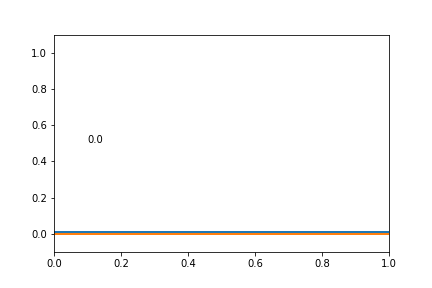
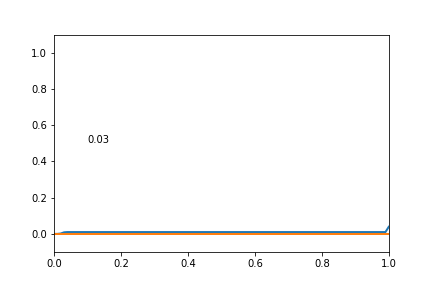
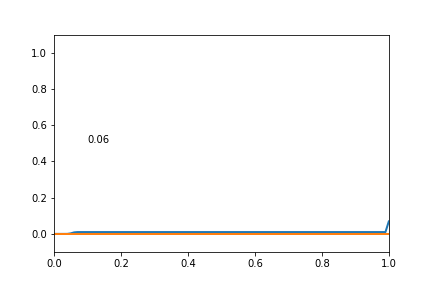
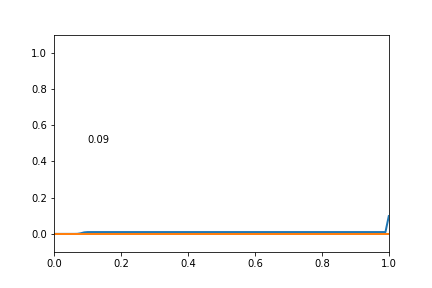
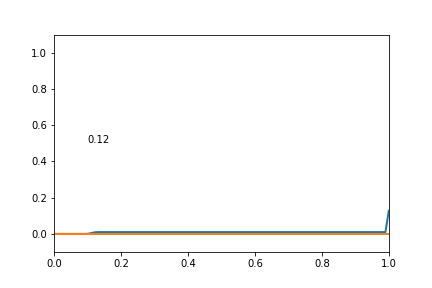
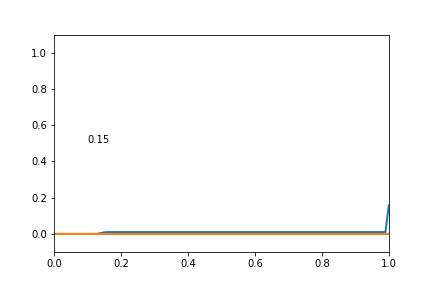
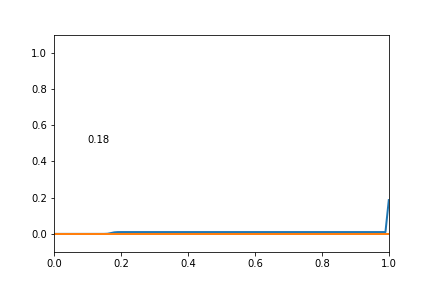
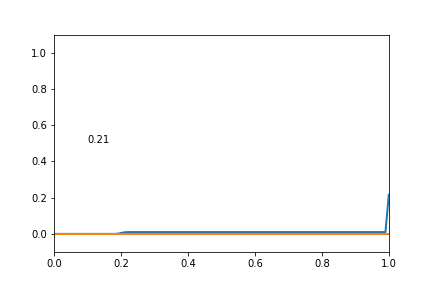
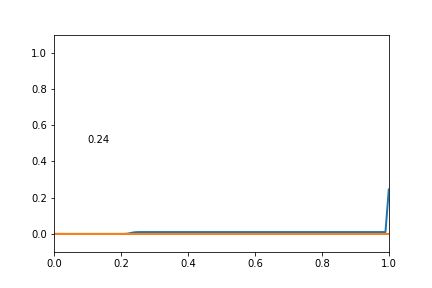
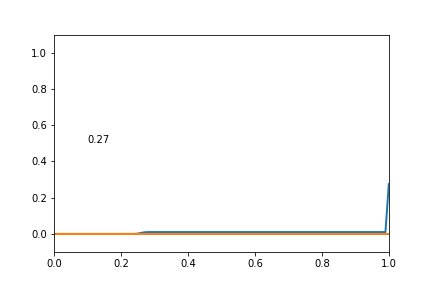
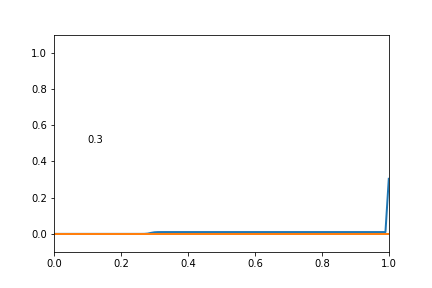
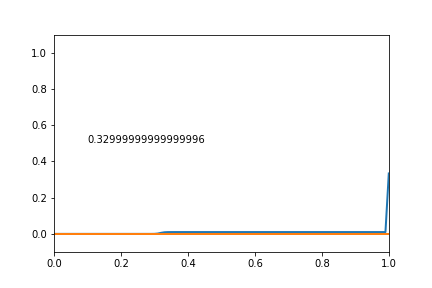
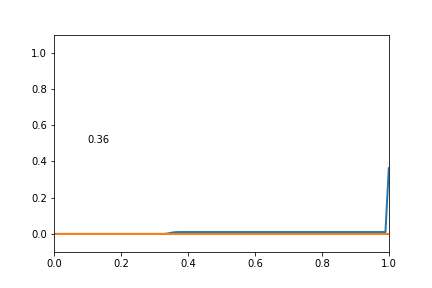
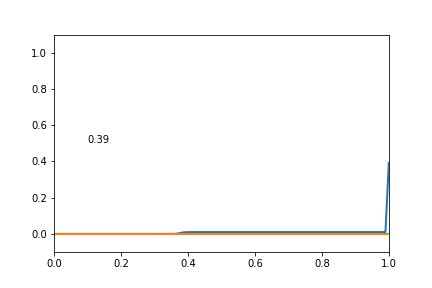
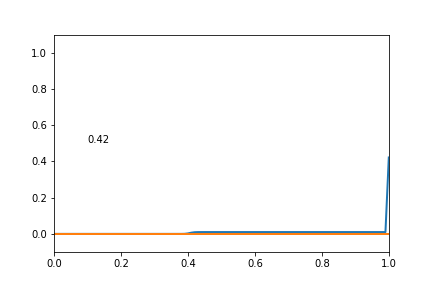
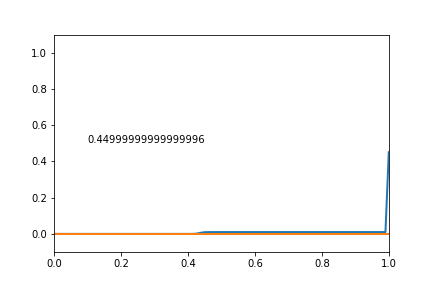
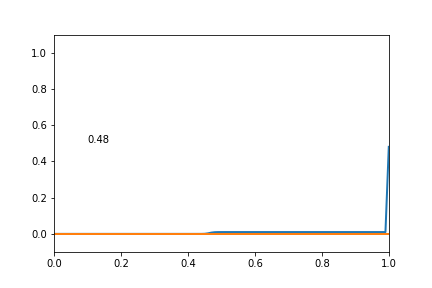
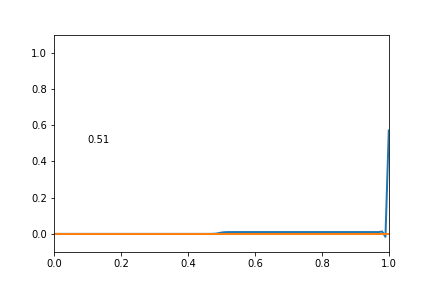
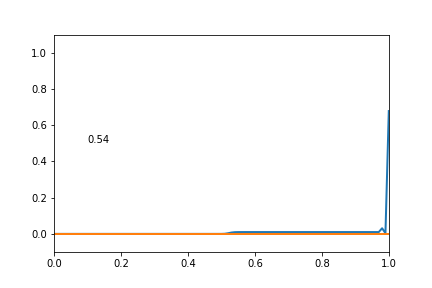
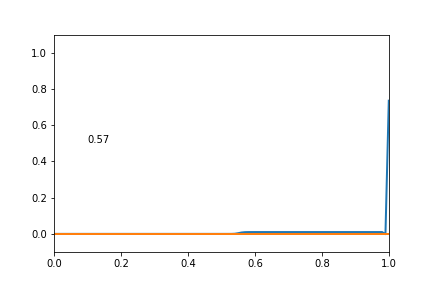
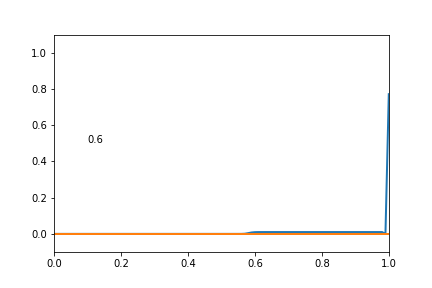
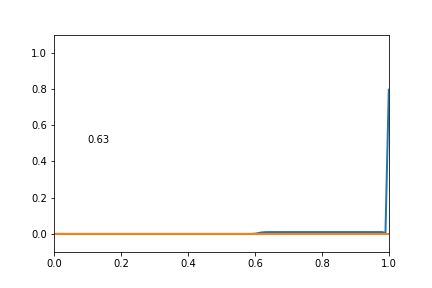
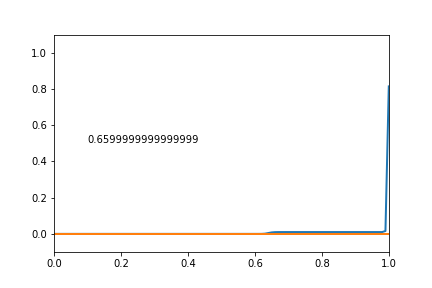
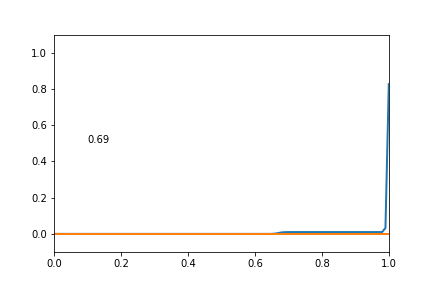
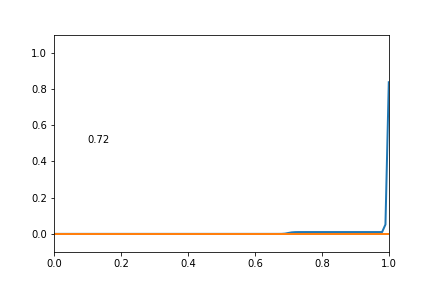
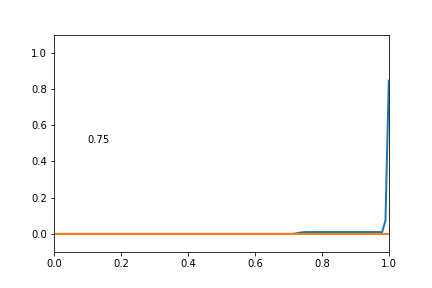
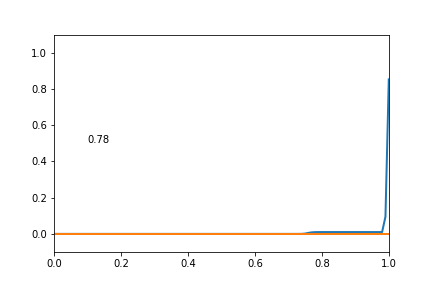
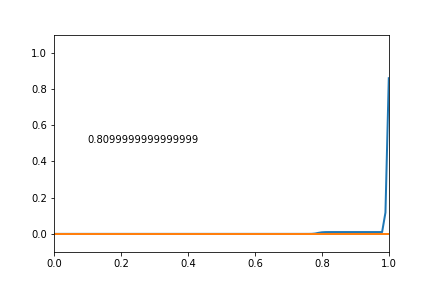
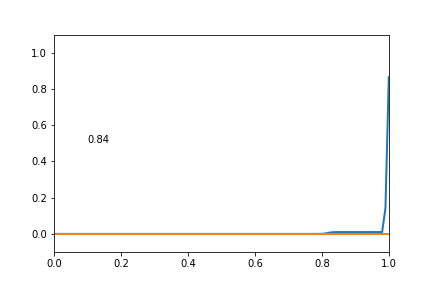
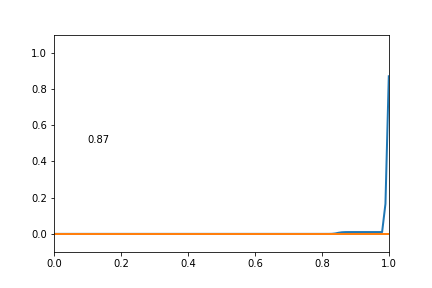
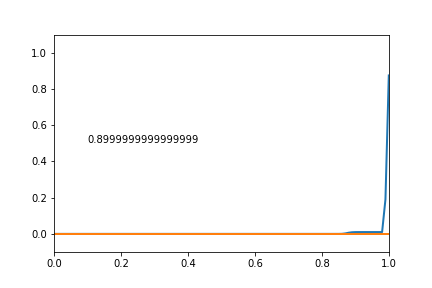
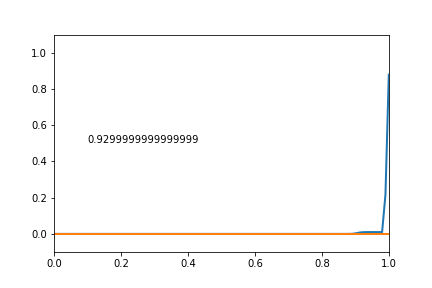
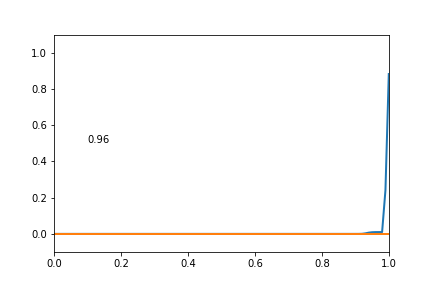
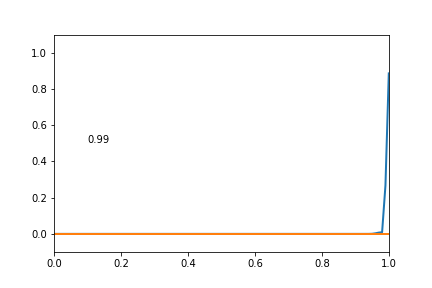
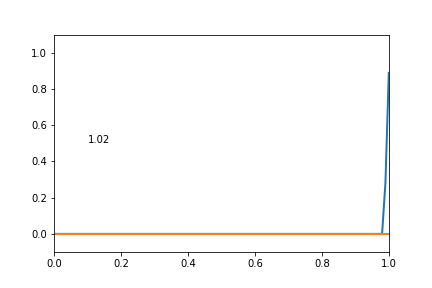
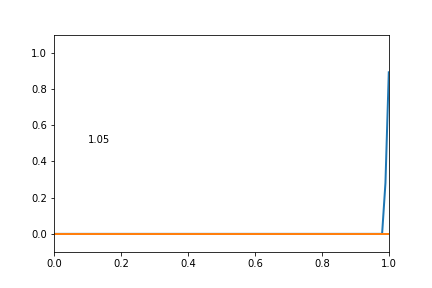
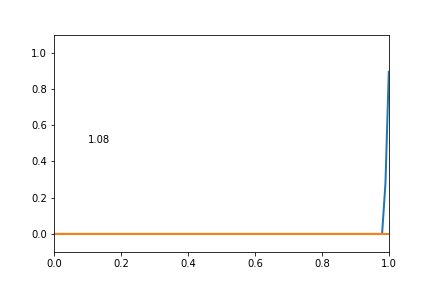
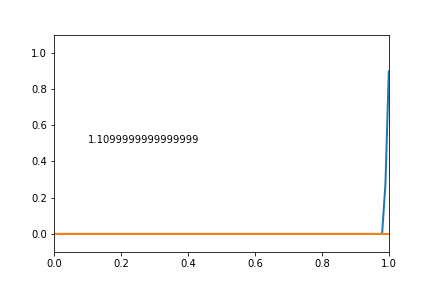
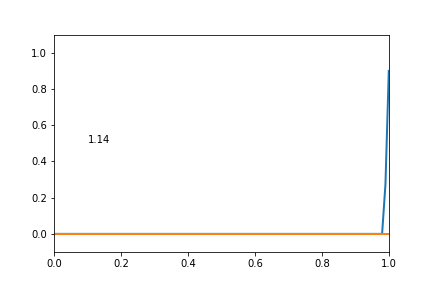
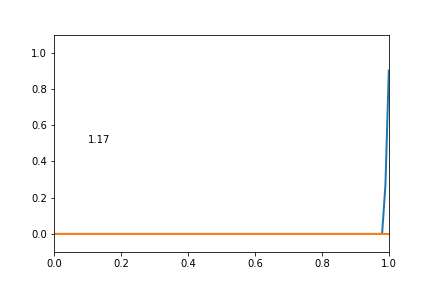
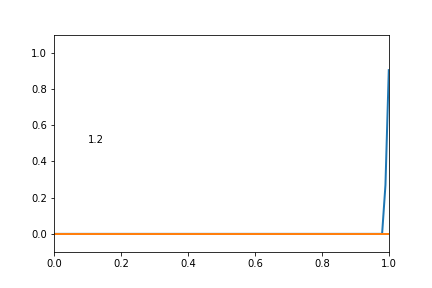
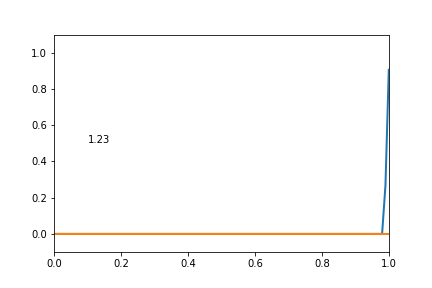
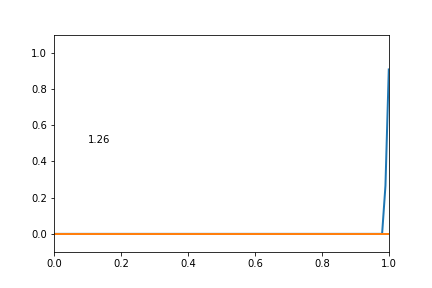
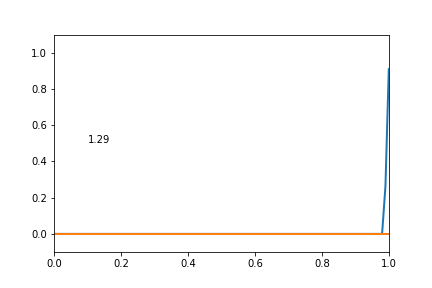
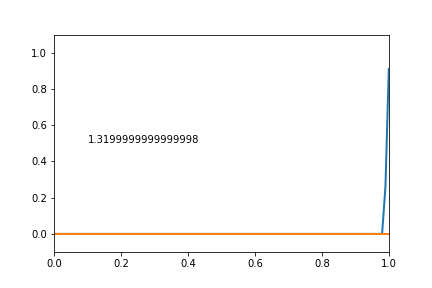
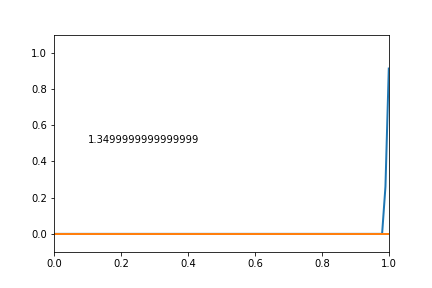
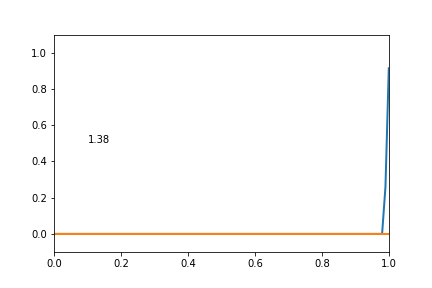
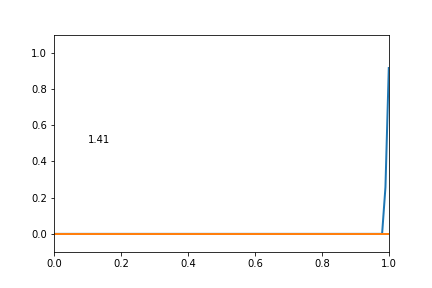
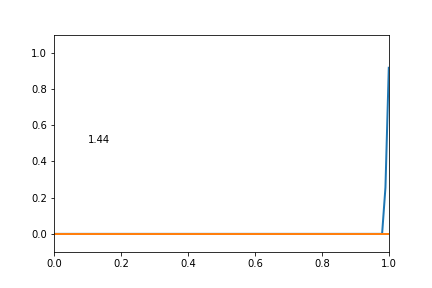
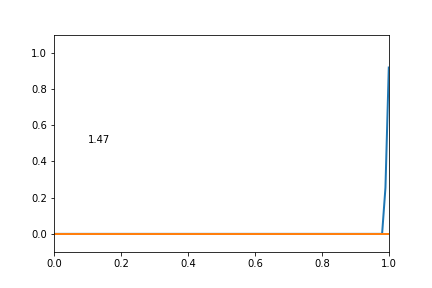
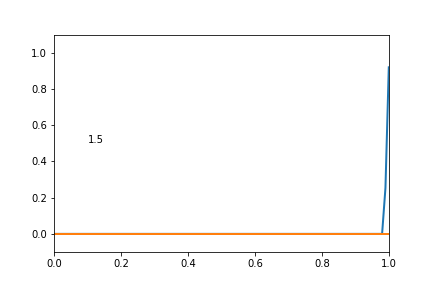
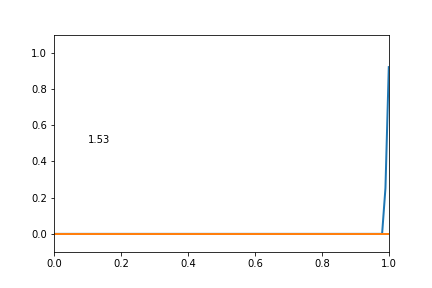
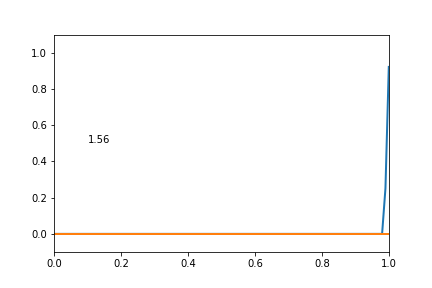
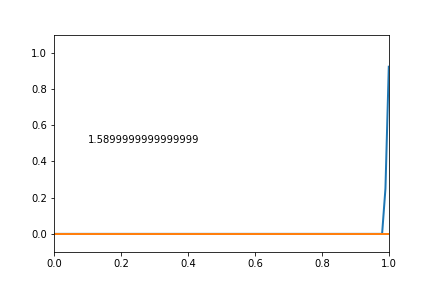
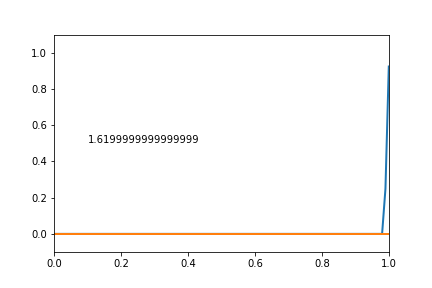
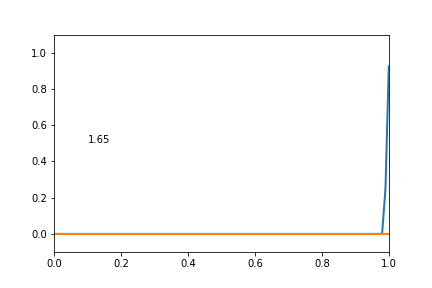
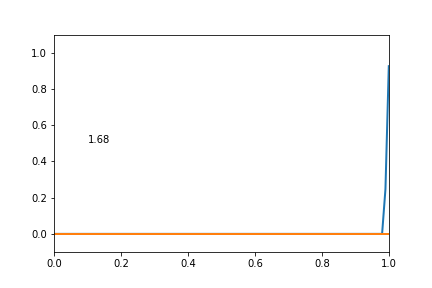
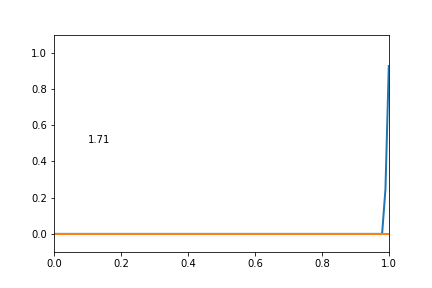
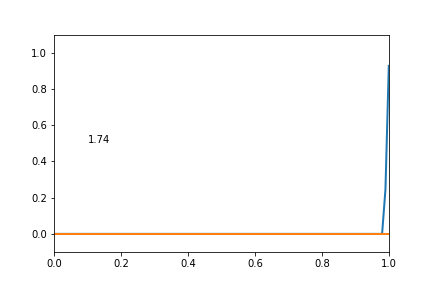
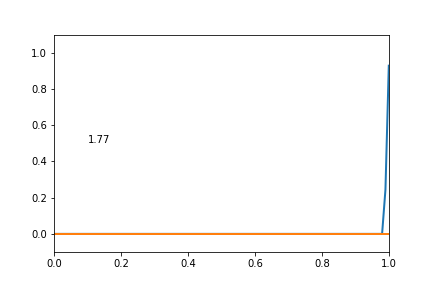
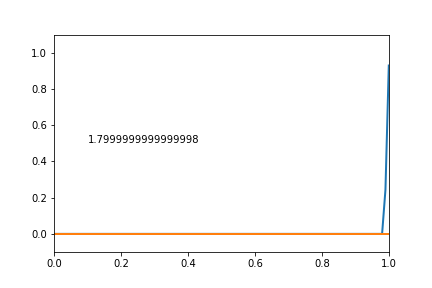
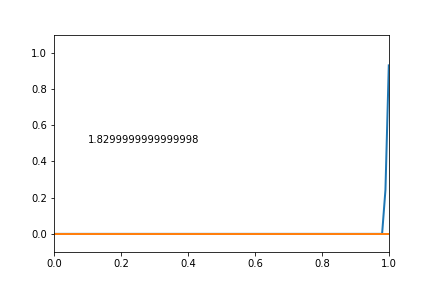
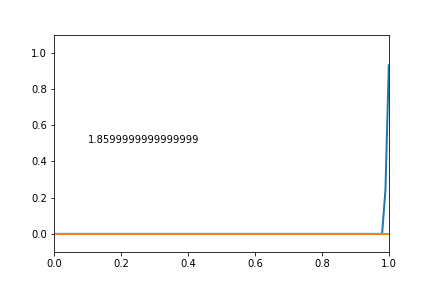
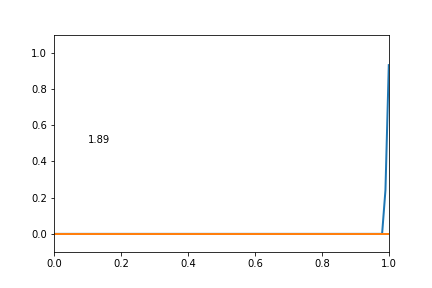
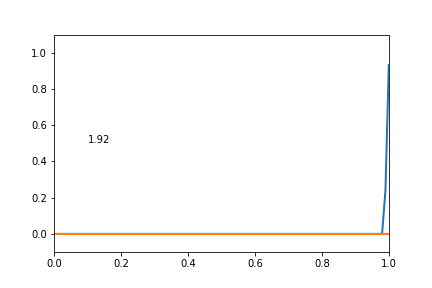
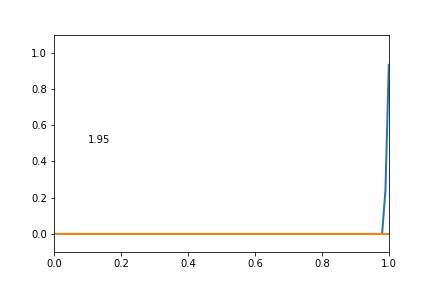
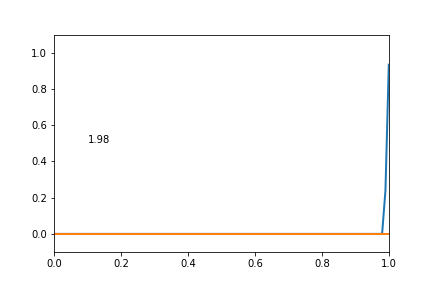
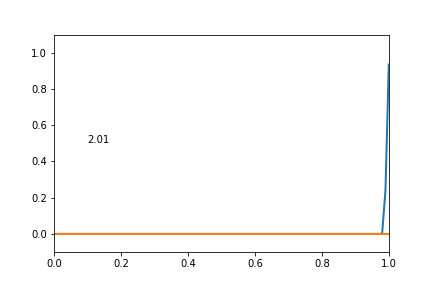
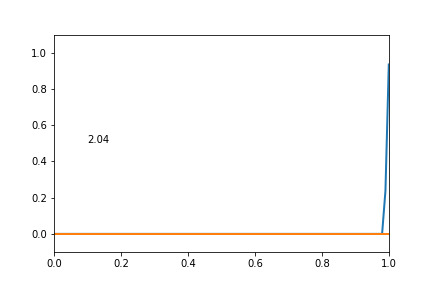
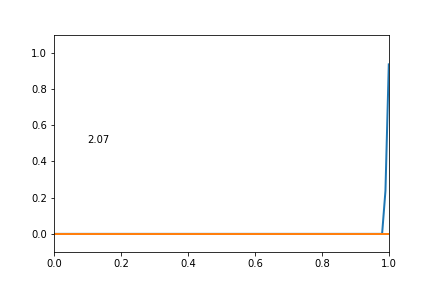
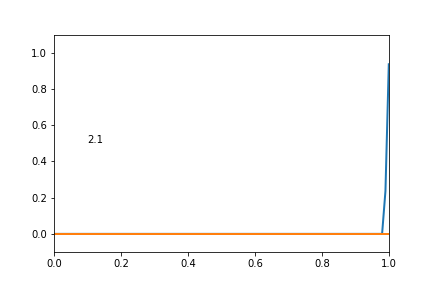
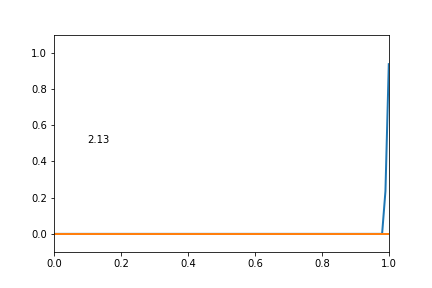
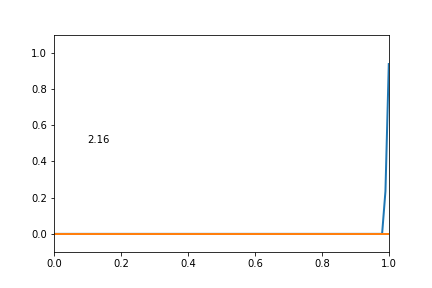
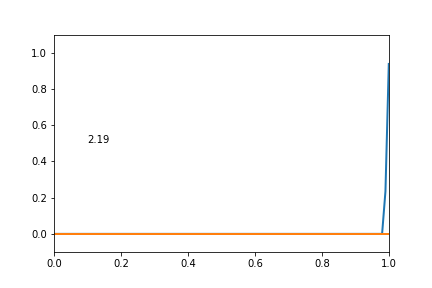
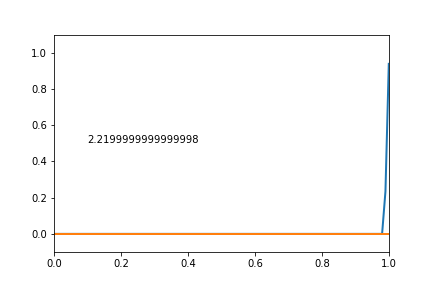
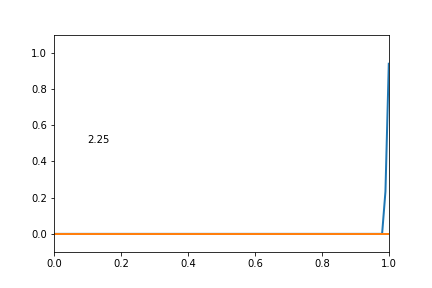
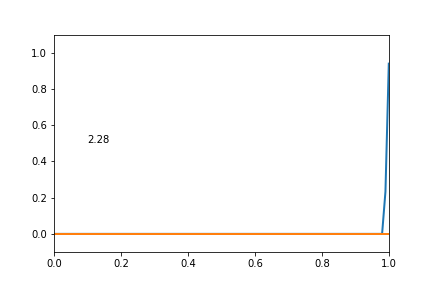
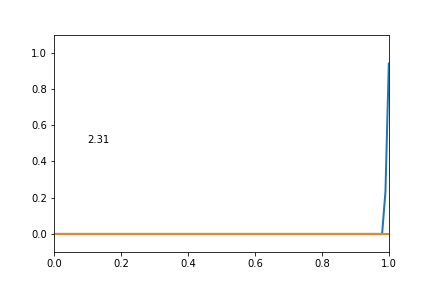
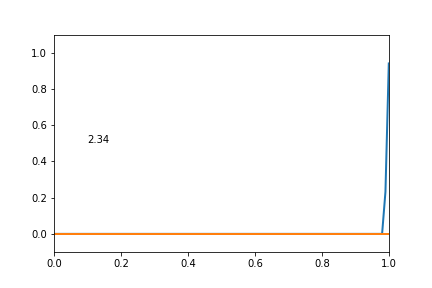
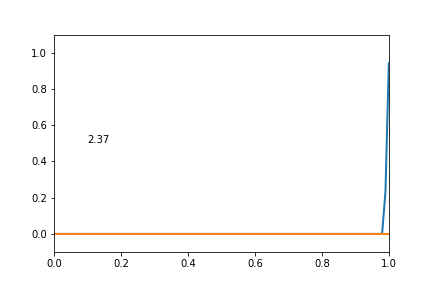
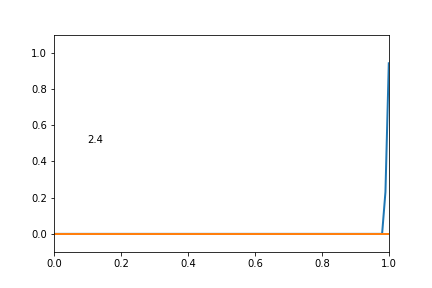
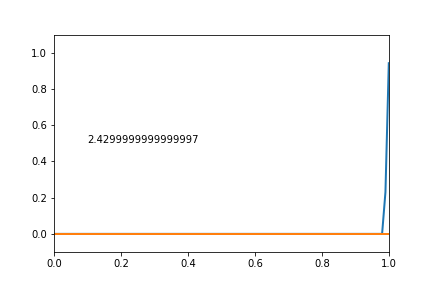
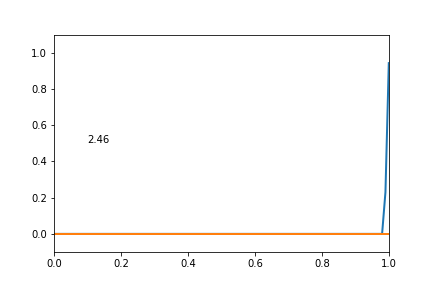
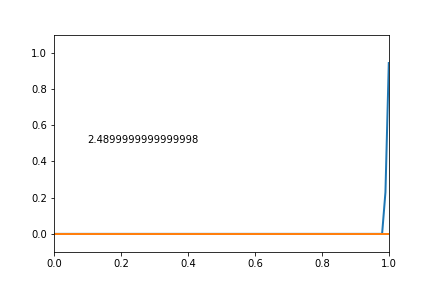
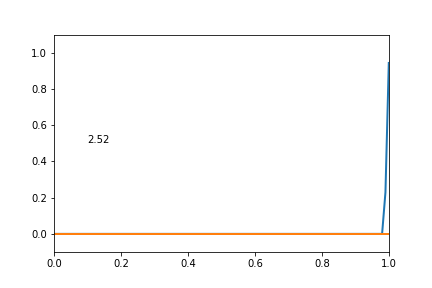
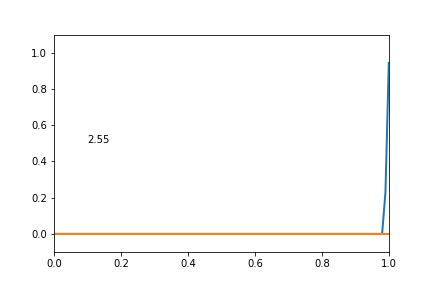
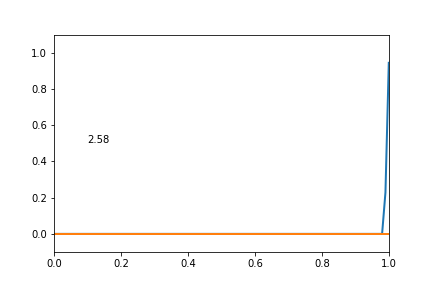
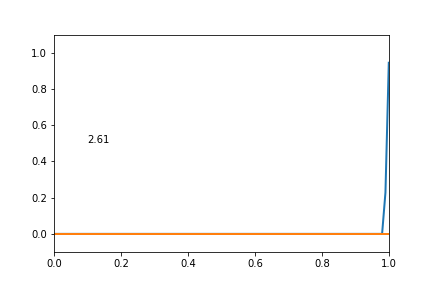
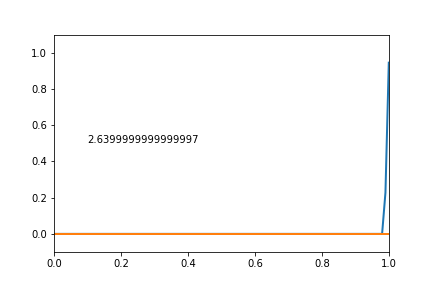
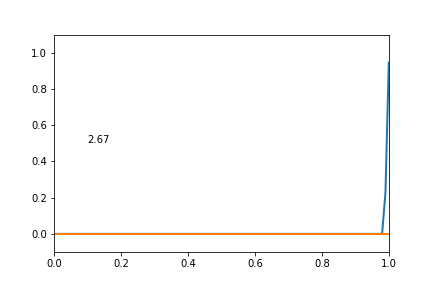
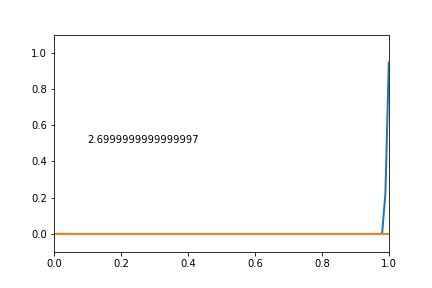
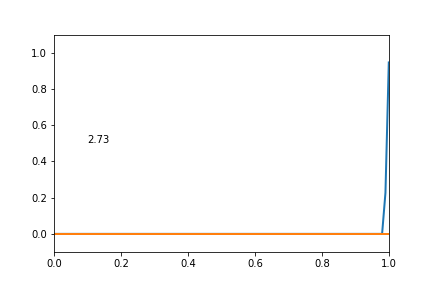
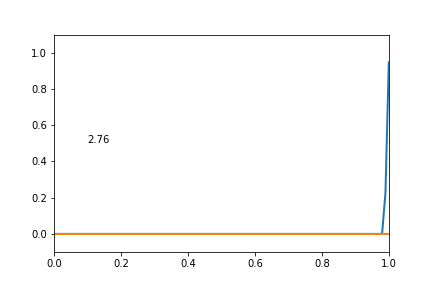
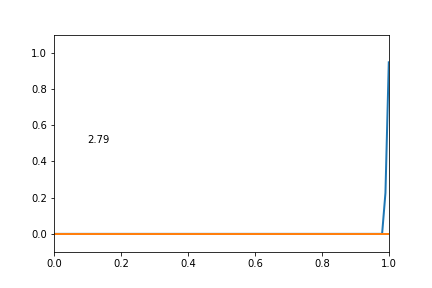
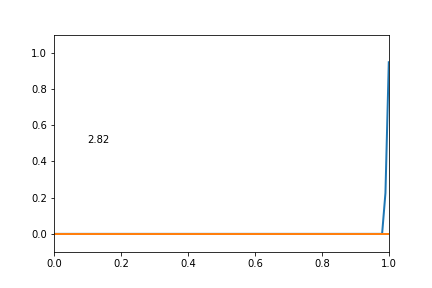
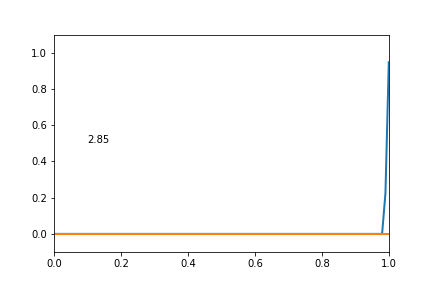
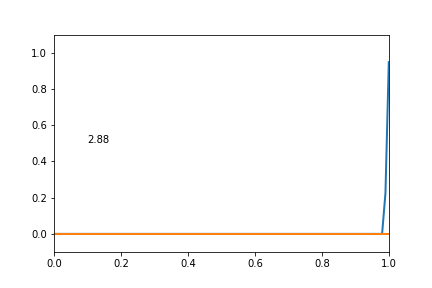
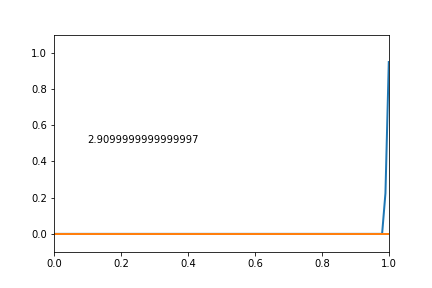
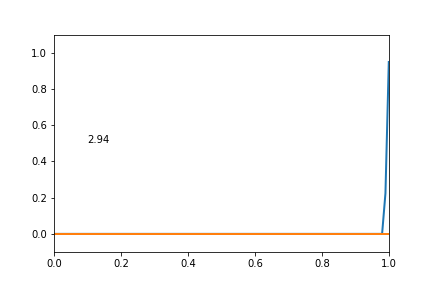
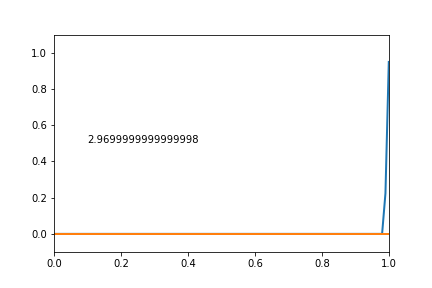
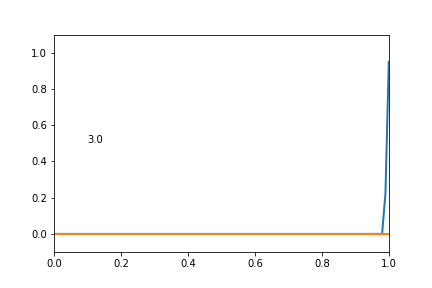

In [23]:
from matplotlib import animation
import matplotlib.pyplot as plt
from clawpack.visclaw.JSAnimation import IPython_display
import numpy as np

# x=domain.grid.x.centers
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.1, 1.1))

frame = claw.frames[0]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
time  = ax.text(0.1,0.5,'hi')

def fplot(frame_number):
    frame = claw.frames[frame_number]
    species1 = frame.q[0,:]
    species2 = frame.q[1,:]
    line1.set_data(xs,species1)
    line2.set_data(xs,species2)
    time.set_text(times[frame_number])
    return line1,line2

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=500)

In [10]:
import importlib
importlib.reload(riemann.advection_nonlinear_1D_py)
# help(riemann.advection_nonlinear_1D_py.abs_flux)
# riemann.advection_nonlinear_1D_py.abs_flux(np.array([0.25,0.30,0.35]),1,hsc_func=None)
# riemann.advection_nonlinear_1D_py.abs_flux(np.array([0.25,0.30,0.35]),1,hsc_func=vf.michaels)

<module 'clawpack.riemann.advection_nonlinear_1D_py' from '/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py'>

### Simulation results

Record nondimensional time for a given HSC

In [11]:
ϕRZ = np.array([0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55])
tRZ = np.array([1.32,1.44,1.56,1.68,1.86,2.04,2.10,2.20,2.52])
ϕMB
plt.scatter(ϕ0,tRZ);

NameError: name 'φMB' is not defined